# 使用简单的感知层PINN实现PDE求解 

A scratch for PINN solving the following PDE:

$u_{xx}-u_{yyyy}=(2-x^2)e^{-y}$

Exact Sol:

$u(x,y)=x^2e^{-y}$

In [3]:
import torch

>Import the torch library to use the basic functions of the neural network.

The Python notebook uses the following functions from the `torch` library: `...`

These functions cover `tensor creation` and `manipulation`, `neural network definition` and `training`, `gradient computation`, and `optimization`. This is indicative of a typical workflow in PyTorch for building and training neural network models, particularly for tasks involving differential equations and gradient calculations.

-------------------

With this loooong code below, the first thing we need to know is the essential principal of the program.

* **What We Need to Solve a Equation**:

    In this Equation in (0,1)(0,1) Domain, we should know what boundary conditions we require to know. Attention that it is a linear equation, what we need to do is to derive that when all the equation is $0$, $u(x,y)=0$. We change the alphabet $x$ into $t$ which refers to the time axis. Then the equation becomes

    $u_{tt}-u_{yyyy}=0$
    and we need $u(t=0,y)$, $\dot u(t=0,y)$, $u_x,u(t,y=0)$ and $u_x,u(t,y=1)$. Anyway, we know that only merely 6 conditions can control the solution.

* **How to do it?**

    The basic principal is base on the **Multiple Layers Perception Mechine**, which I don't wanna explain in this part.

    Anyway, our high-level steps is like this graph.
    ```mermaid
    graph LR
    A[Import Data]-->B[Create Model]-->C[Training]-->D[Prediction]-->E[Output Prediction]
    ```

* **How to Build Our Model**

    See it below.
---------------------

## Import Data


In [4]:
# Domain and Sampling
def interior(n=1000):
    x = torch.rand(n, 1)
    y = torch.rand(n, 1)
    cond = (2 - x ** 2) * torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond.requires_grad_(True)



Create the training data set with the solution function $u(x,y)=x^2e^{-y}$

Below the original data are the boundary conditions, which contains the $u_{yy}$ & $u$ in $y=0$ and $y=1$ and $u$ in $x=0$ or $1$. (Count it! And you can find that the num is 6!😋)

In [5]:

def down_yy(n=100):
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x ** 2
    return x.requires_grad_(True), y.requires_grad_(True), cond.requires_grad_(True)


def up_yy(n=100):
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x ** 2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down(n=100):
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x ** 2
    return x.requires_grad_(True), y.requires_grad_(True), cond

def up(n=100):
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x ** 2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond

def left(n=100):
    y = torch.rand(n, 1)
    x = torch.zeros_like(y)
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def right(n=100):
    y = torch.rand(n, 1)
    x = torch.ones_like(y)
    cond = torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond



## Create Model 

* Here are the main part of the model.

    It builds a basic module, which contains the attribute `net`, containing all the parameters in the `Sequential` net and a `forword` __call__-method which can tranforming the input $(x,y)$ into the output $f$.

In [6]:

# Neural Network
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)



* Define The Loss Function

In [7]:

# Loss
loss = torch.nn.MSELoss()

In [8]:
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   only_inputs=True, )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)



The gradient function $\nabla$

The following are the main paart of loss func, and in order, that is 
* $l-interior = \sum (u_{xx}-u_{yyyy}-(2-x^2)e^{-y})^2$
* $ l-down-yy = \sum (u_{yy}|_{y=0}-cond)^2$
* $ l-up-yy = \sum (u_{yy}|_{y=1}-cond)^2$
* $ l-down = \sum (u|_{y=0}-cond)^2$
* $ l-up = \sum (u|_{y=1}-cond)^2$
* $ l-left = \sum (u|_{x=0}-cond)^2$
* $ l-right = \sum (u|_{x=1}-cond)^2$

In [9]:

def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x, y], dim=1))  # Where `u=MLP()` is the neural network, and it contain in a concealed function `u.__call__` meant to be 'forward' function
    return loss(gradients(uxy, x, 2) - gradients(uxy, y, 4), cond)



In [10]:

def l_down_yy(u):
    x, y, cond = down_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)



In [11]:

def l_up_yy(u):
    x, y, cond = up_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)



In [12]:

def l_down(u):
    x, y, cond = down()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)



In [13]:

def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


In [14]:


def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)



In [15]:

def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


## Training

Attention that we have defined module MLP.
<br>

* Adam() is a SGD method using momentum and adaptive learning rate.

In [16]:
# Training

u = MLP()
opt = torch.optim.Adam(params=u.parameters())
for i in range(1000):
    opt.zero_grad()
    l = l_interior(u) \
        + l_up_yy(u) \
        + l_down_yy(u) \
        + l_up(u) \
        + l_down(u) \
        + l_left(u) \
        + l_right(u)
    l.backward()
    opt.step()
    if i%100 == 0: print(i)



0
100
200
300
400
500
600
700
800
900


## Prediction

And computing The magnitude of error

In [27]:
# Inference
xc = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(xc, xc)
print(xx)
print(yy)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)
u_pred = u(xy)
print("Max abs error is: ", float(torch.max(torch.abs(u_pred - xx * xx * torch.exp(-yy)))))



tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101],
        [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
        ...,
        [0.9798, 0.9798, 0.9798,  ..., 0.9798, 0.9798, 0.9798],
        [0.9899, 0.9899, 0.9899,  ..., 0.9899, 0.9899, 0.9899],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])
tensor([[0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        ...,
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
        [0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000]])
Max abs error is:  0.007539108395576477


## Output Prediction

[[0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 ...
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.01010101 0.01010101 0.01010101 ... 0.01010101 0.01010101 0.01010101]
 [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
 ...
 [0.97979798 0.97979798 0.97979798 ... 0.97979798 0.97979798 0.97979798]
 [0.98989899 0.98989899 0.98989899 ... 0.98989899 0.98989899 0.98989899]
 [1.         1.         1.         ... 1.         1.         1.        ]]


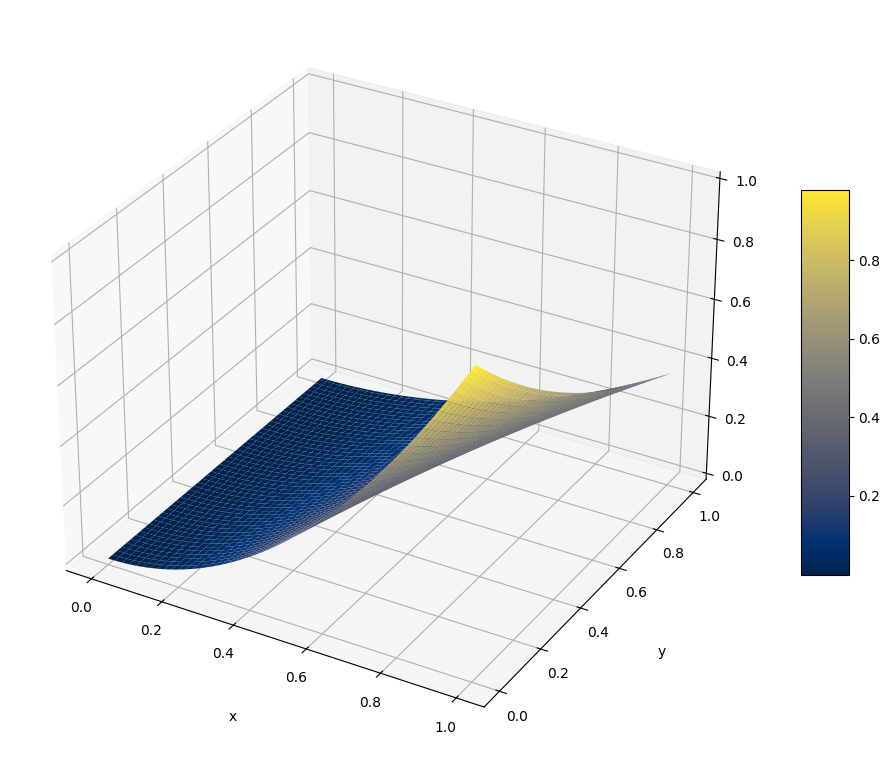

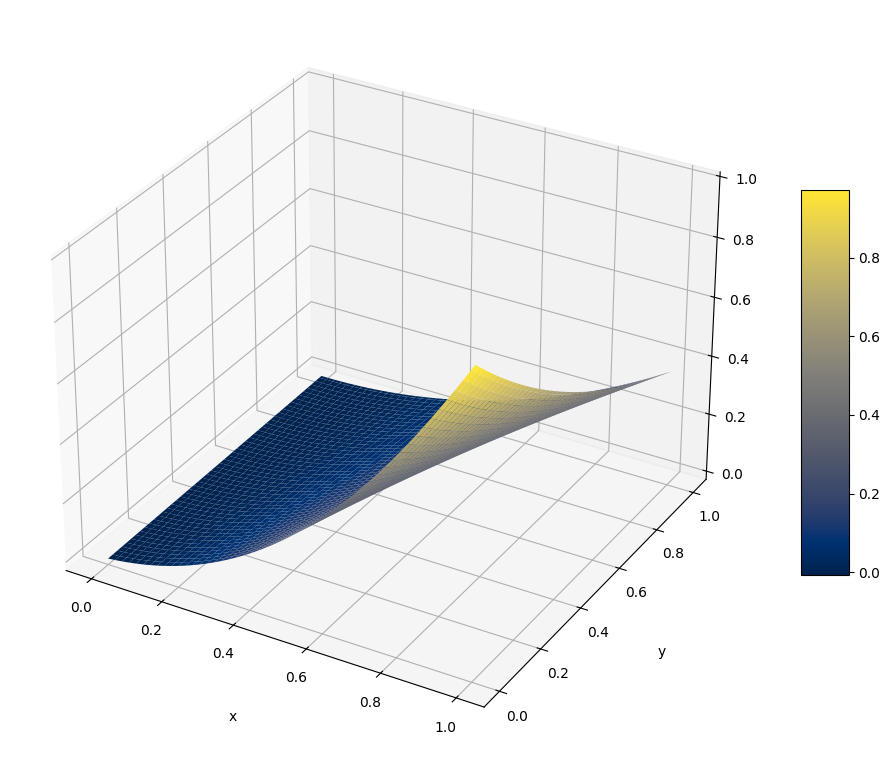

In [26]:
# Plot
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
print(X)
print(Y)
Z=X**2*np.exp(-Y)
# surf = ax.plot_surface(X, Y, u_pred.detach().numpy().reshape(100, 100), cmap = plt.cm.cividis)

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()


fig2 = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, u_pred.detach().numpy().reshape(100, 100).T, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig2.colorbar(surf, shrink=0.5, aspect=8)

plt.show()